# K-Means from Scratch (with K-Means++) for Ishihara Test

This notebook implements the K-Means clustering algorithm from scratch, including the K-Means++ initialization method and multiple initializations (`n_init`) for robustness. It then applies this implementation to an Ishihara color blindness test image.

The approach focuses on the 'a' channel of the LAB color space to distinguish between the typically reddish/orange numbers and the greenish/bluish background dots.

**Steps:**
1.  **Run Setup Cells:** Execute the cells containing imports, the `KMeans` class definition, and the `process_image` function definition.
2.  **Upload Image:** Run the "Upload Image" cell and use the 'Choose Files' button to upload your Ishihara test image (e.g., `74.jpg`, `12.jpg`).
3.  **Process Image:** Run the final cell. It will load the uploaded image, apply K-Means clustering on the 'a' channel, and display the original image alongside a binary mask attempting to show the extracted number.

## Step 1: Imports and Algorithm Definitions

In [1]:
# --- Imports ---
import numpy as np
import cv2 # OpenCV for image processing
import matplotlib.pyplot as plt
from google.colab import files # For file upload in Colab
import os # For path checking

In [2]:
# --- K-Means Class Definition (with K-Means++) ---
class KMeans:
    """K-Means clustering implementation from scratch.

    Uses K-Means++ for initialization and supports multiple runs (n_init).
    Mimics scikit-learn's API conventions.
    """
    def __init__(self, n_clusters=8, init='k-means++', n_init=10,
                 max_iter=300, tol=1e-4, random_state=None):
        """Initialize K-Means.

        Args:
            n_clusters (int): The number of clusters to form.
            init (str): Method for initialization, {'k-means++', 'random'}.
            n_init (int): Number of times the k-means algorithm will be run with
                          different centroid seeds. The final result will be the best
                          output of n_init consecutive runs in terms of inertia.
            max_iter (int): Maximum number of iterations for a single run.
            tol (float): Relative tolerance with regard to Frobenius norm of the
                         difference in the cluster centers of two consecutive iterations
                         to declare convergence.
            random_state (int or np.random.RandomState): Determines random number
                                                        generation for centroid initialization.
        """
        self.n_clusters = n_clusters
        self.init = init
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        # Initialize random state properly
        if isinstance(random_state, np.random.RandomState):
            self.random_state = random_state
        else:
            self.random_state = np.random.RandomState(random_state)

        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None
        self.n_iter_ = 0

    def _kmeans_plusplus(self, X):
        """Initialize centers using K-Means++ algorithm."""
        n_samples, n_features = X.shape
        centers = np.empty((self.n_clusters, n_features), dtype=X.dtype)

        # 1. Choose the first center randomly from the data points
        center_id = self.random_state.choice(n_samples)
        centers[0] = X[center_id]

        # Initialize closest distances squared (D^2)
        closest_dist_sq = np.sum((X - centers[0])**2, axis=1)

        # 2. Choose remaining centers
        for c in range(1, self.n_clusters):
            # Calculate probabilities proportional to D^2
            probs = closest_dist_sq / np.sum(closest_dist_sq)
            # Choose next center based on probabilities
            next_center_id = self.random_state.choice(n_samples, p=probs)
            centers[c] = X[next_center_id]

            # Update closest distances squared
            new_dist_sq = np.sum((X - centers[c])**2, axis=1)
            closest_dist_sq = np.minimum(closest_dist_sq, new_dist_sq)

        return centers

    def _lloyd_iter(self, X, centers):
        """Perform one run of K-Means (Lloyd's algorithm)."""
        best_centers = centers.copy()
        best_labels = None
        best_inertia = np.inf

        for i in range(self.max_iter):
            # E-step: Assign points to the closest cluster center
            # Calculate squared distances from each point to each center
            distances_sq = np.sum((X[:, np.newaxis, :] - centers[np.newaxis, :, :])**2, axis=2)
            labels = np.argmin(distances_sq, axis=1)

            # M-step: Update cluster centers to the mean of assigned points
            new_centers = np.empty_like(centers)
            for j in range(self.n_clusters):
                cluster_points = X[labels == j]
                if cluster_points.shape[0] > 0:
                    new_centers[j] = cluster_points.mean(axis=0)
                else:
                    # Re-initialize empty clusters (choose a random point)
                    # A more sophisticated strategy might choose the farthest point
                    new_centers[j] = X[self.random_state.choice(X.shape[0])]

            # Check for convergence
            center_shift_sq = np.sum((new_centers - centers)**2)
            centers = new_centers
            if center_shift_sq <= self.tol:
                break

        # Calculate final labels and inertia for this run
        final_distances_sq = np.sum((X[:, np.newaxis, :] - centers[np.newaxis, :, :])**2, axis=2)
        labels = np.argmin(final_distances_sq, axis=1)
        inertia = np.sum(final_distances_sq[np.arange(len(final_distances_sq)), labels])

        return centers, labels, inertia, i + 1 # Return number of iterations performed

    def fit(self, X):
        """Compute k-means clustering.

        Args:
            X (array-like or sparse matrix): Training instances to cluster, shape (n_samples, n_features).
        """
        X = np.asarray(X, dtype=np.float64) # Ensure data is numpy array
        best_inertia = np.inf

        # Run the algorithm n_init times and keep the best result
        for run_idx in range(self.n_init):
            # Initialize centers
            if self.init == 'k-means++':
                initial_centers = self._kmeans_plusplus(X)
            elif self.init == 'random':
                indices = self.random_state.choice(X.shape[0], self.n_clusters, replace=False)
                initial_centers = X[indices]
            else:
                raise ValueError(f"Invalid init parameter: '{self.init}'. Should be 'k-means++' or 'random'.")

            # Run Lloyd's algorithm for this initialization
            centers, labels, inertia, n_iter = self._lloyd_iter(X, initial_centers)

            # Store the best result so far (lowest inertia)
            if inertia < best_inertia:
                self.cluster_centers_ = centers
                self.labels_ = labels
                self.inertia_ = inertia
                self.n_iter_ = n_iter
                best_inertia = inertia

        return self

    def predict(self, X):
        """Predict the closest cluster each sample in X belongs to.

        Args:
            X (array-like): New data to predict, shape (n_samples, n_features).

        Returns:
            ndarray: Index of the cluster each sample belongs to, shape (n_samples,).
        """
        if self.cluster_centers_ is None:
            raise RuntimeError("KMeans instance has not been fitted yet. Call 'fit' first.")

        X = np.asarray(X, dtype=np.float64) # Ensure data is numpy array
        # Calculate squared distances and return the index of the minimum distance (closest center)
        distances_sq = np.sum((X[:, np.newaxis, :] - self.cluster_centers_[np.newaxis, :, :])**2, axis=2)
        return np.argmin(distances_sq, axis=1)


In [20]:
# --- Image Processing Function ---
def process_image(image_path, num_clusters=2):
    """Loads an image, applies K-Means on the LAB 'a' channel,
       and displays the original and extracted number mask.

       Args:
           image_path (str): Path to the image file.
           num_clusters (int): Number of clusters (typically 2 for Ishihara).
    """
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return

    # Convert BGR (OpenCV default) to RGB (Matplotlib default)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Extract the 'a' channel (represents green-red axis)
    # Reshape for clustering (KMeans expects 2D array: n_samples x n_features)
    # Here, each pixel's 'a' value is a sample, and we have 1 feature ('a' value)
    a_channel = lab[:, :, 1].astype(np.float64) # Use float for calculations
    X = a_channel.reshape(-1, 1)

    # Optional: Normalize the 'a' channel (can sometimes help)
    # Comment this out if you want to work with raw 'a' values
    # X = (X - X.mean()) / X.std()

    print(f"Applying K-Means with k={num_clusters}...")
    # Apply K-Means
    # Use random_state for reproducible results
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X)

    # Get the labels for each pixel and reshape back to image dimensions
    labels = kmeans.predict(X).reshape(lab.shape[:2])

    # --- Heuristic to find the 'number' cluster ---
    # In LAB space, 'a' channel: higher values -> more red/magenta, lower values -> more green.
    # Ishihara numbers are often reddish/orange (higher 'a') on a greenish background (lower 'a').
    # So, the cluster center with the *higher* 'a' value likely corresponds to the number.
    # Note: This heuristic might fail if the image colors are unusual.
    number_cluster_index = np.argmax(kmeans.cluster_centers_)
    print(f"Heuristically determined 'number' cluster index: {number_cluster_index} (center value: {kmeans.cluster_centers_[number_cluster_index][0]:.2f})")
    print(f"Other cluster center value: {kmeans.cluster_centers_[1 - number_cluster_index][0]:.2f}")

    # Create a binary mask: White (255) for pixels in the 'number' cluster, Black (0) otherwise.
    binary_mask = (labels == number_cluster_index).astype(np.uint8) * 255

    # --- Display results ---
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(binary_mask, cmap='gray')
    plt.title(f'Extracted Number (Cluster {number_cluster_index})')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # --- Print clustering details ---
    print("\n--- Clustering Details ---")
    print(f"Cluster Centers ('a' channel value): {kmeans.cluster_centers_.flatten()}")
    # Calculate cluster sizes
    cluster_sizes = [np.sum(labels == i) for i in range(num_clusters)]
    print(f"Cluster Sizes (pixels): {cluster_sizes}")
    print(f"Inertia (sum of squared distances): {kmeans.inertia_:.2f}")
    print(f"Number of iterations for best run: {kmeans.n_iter_}")

## Step 2: Upload Ishihara Image

In [27]:
print('Please upload your Ishihara test image:')
uploaded = files.upload()

# Get the filename of the uploaded file
img_filename = None
if not uploaded:
  print("\nNo file uploaded. Please re-run this cell and upload an image.")
else:
  # Get the first uploaded filename (assuming only one file)
  img_filename = next(iter(uploaded))
  print(f'\nSuccessfully uploaded: {img_filename}')

  # Define the path where Colab stores the uploaded file
  img_path_in_colab = img_filename # In Colab's root temporary directory

  # Verify the file exists at the expected path
  if not os.path.exists(img_path_in_colab):
    print(f"Error: Uploaded file '{img_path_in_colab}' could not be found immediately after upload. This might be a temporary Colab issue.")
    img_filename = None # Reset filename if not found
  else:
    print(f"Image path set to: {img_path_in_colab}")

Please upload your Ishihara test image:


Saving 74.jpg to 74 (1).jpg

Successfully uploaded: 74 (1).jpg
Image path set to: 74 (1).jpg


## Step 3: Process the Uploaded Image

Applying K-Means with k=2...
Heuristically determined 'number' cluster index: 1 (center value: 149.09)
Other cluster center value: 126.41


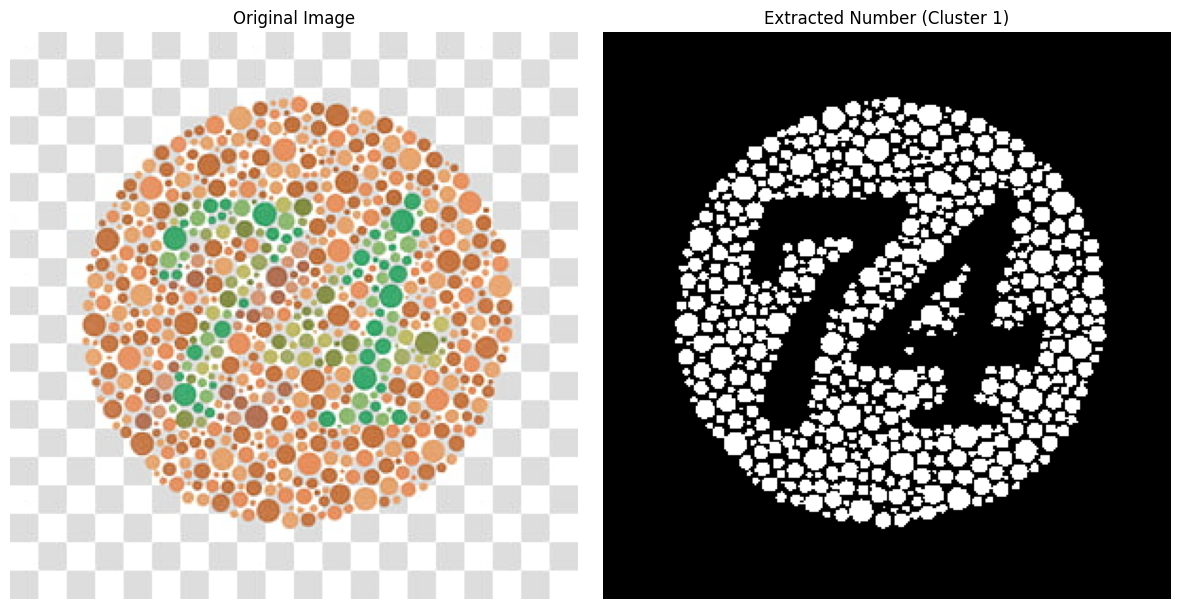


--- Clustering Details ---
Cluster Centers ('a' channel value): [126.40670273 149.08601009]
Cluster Sizes (pixels): [np.int64(71165), np.int64(18835)]
Inertia (sum of squared distances): 5290040.47
Number of iterations for best run: 4


In [28]:
# Check if a filename was successfully stored from the upload step
if img_filename and os.path.exists(img_filename):
    # Run the processing function on the uploaded image
    # We expect 2 clusters for typical Ishihara: number vs background
    process_image(img_filename, num_clusters=2)
else:
    print("Cannot process image. Please successfully upload an image in the previous step.")
